In [1]:
import os
from os.path import join
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
np.random.seed(2)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import splitfolders

In [2]:
INPUT_PATH = './17FlowerOxfordDataset'
print(os.listdir(INPUT_PATH))

['bluebell', 'buttercup', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'pansy', 'rose', 'snowdrop', 'sunflower', 'tiger lily', 'tulip', 'windflower']


In [3]:
splitfolders.ratio(INPUT_PATH, seed=1337, output="Dataset_CV", ratio=(0.8,0.1,0.1))

Copying files: 1360 files [00:02, 603.09 files/s]


In [4]:
train = './Dataset_CV/train'
val = './Dataset_CV/val'
test = './Dataset_CV/test'

In [5]:
img_folders_train = [join(train, dir) for dir in os.listdir(train)]
img_folders_val  = [join(val, dir) for dir in os.listdir(val)]
img_folders_test = [join(test, dir) for dir in os.listdir(test)]
list(img_folders_train)
list(img_folders_val)
list(img_folders_test)

['./Dataset_CV/test\\bluebell',
 './Dataset_CV/test\\buttercup',
 './Dataset_CV/test\\cowslip',
 './Dataset_CV/test\\crocus',
 './Dataset_CV/test\\daffodil',
 './Dataset_CV/test\\daisy',
 './Dataset_CV/test\\dandelion',
 './Dataset_CV/test\\fritillary',
 './Dataset_CV/test\\iris',
 './Dataset_CV/test\\pansy',
 './Dataset_CV/test\\rose',
 './Dataset_CV/test\\snowdrop',
 './Dataset_CV/test\\sunflower',
 './Dataset_CV/test\\tiger lily',
 './Dataset_CV/test\\tulip',
 './Dataset_CV/test\\windflower']

In [6]:
images_train = load_files(train)
images_val = load_files(val)
images_test = load_files(test)
X_train = np.array(images_train['filenames'])
y_train = np.array(images_train['target'])
X_val = np.array(images_val['filenames'])
y_val = np.array(images_val['target'])
X_test = np.array(images_test['filenames'])
y_test = np.array(images_test['target'])

labels_train = np.array(images_train['target_names'])
labels_val = np.array(images_val['target_names'])
labels_test = np.array(images_test['target_names'])

In [7]:
print(f'Target labels train (digits) - {y_train}')
print(f'Target labels train (names) - {labels_train}')
print(f'Number of uploaded train images : {X_train.shape[0]}')

print(f'Target labels val (digits) - {y_val}')
print(f'Target labels val (names) - {labels_val}')
print(f'Number of uploaded val images : {X_val.shape[0]}')

print(f'Target labels test (digits) - {y_test}')
print(f'Target labels test (names) - {labels_test}')
print(f'Number of uploaded test images : {X_test.shape[0]}')

Target labels train (digits) - [11 13 10 ... 11  8 10]
Target labels train (names) - ['bluebell' 'buttercup' 'cowslip' 'crocus' 'daffodil' 'daisy' 'dandelion'
 'fritillary' 'iris' 'pansy' 'rose' 'snowdrop' 'sunflower' 'tiger lily'
 'tulip' 'windflower']
Number of uploaded train images : 1088
Target labels val (digits) - [14  4  5 14 10  1  6 12  2 13  6 11  3  9  5 11  6  8 15 11  0  3 11  1
  7 11  2  0  6  7 10  6  3 13  8  7  7 13 15  1  5 13  7 10  1  7  5 12
 15  0 12 13  0 11 12 12  9 14  9  8 11 12  3  2 15  1 10 11  5 11  0 11
 14  5  0  2  4  0  6 15 13  0  4  3  6  9  4  2  9  3 11  7 12 14  4 14
  1 11  2  3  6 13 11 10  8 15  9  8 10  2 15  9  9  3  4 10 14  5 15  4
 11  8  7  1 14 11  8 10  4  2  1 11  8 13  5]
Target labels val (names) - ['bluebell' 'buttercup' 'cowslip' 'crocus' 'daffodil' 'daisy' 'dandelion'
 'fritillary' 'iris' 'pansy' 'rose' 'snowdrop' 'sunflower' 'tiger lily'
 'tulip' 'windflower']
Number of uploaded val images : 135
Target labels test (digits) - [ 3

In [8]:
flowers_train = pd.DataFrame({'species': y_train})
flowers_train.count()

species    1088
dtype: int64

In [9]:
flowers_val = pd.DataFrame({'species': y_val})
flowers_val.count()

species    135
dtype: int64

In [10]:
flowers_test = pd.DataFrame({'species': y_test})
flowers_test.count()

species    137
dtype: int64

In [11]:
flowers_train['flower'] = flowers_train['species'].astype('category')
labels_train = flowers_train['flower'].cat.categories

In [12]:
flowers_val['flower'] = flowers_val['species'].astype('category')
labels_val = flowers_val['flower'].cat.categories

In [13]:
flowers_test['flower'] = flowers_test['species'].astype('category')
labels_test = flowers_test['flower'].cat.categories

In [14]:
labels_train
labels_val
labels_test

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int32')

In [15]:
image_size = 150

In [16]:
def imageLoadConverter(img_paths):
    images = [load_img(img_path, target_size=(image_size, image_size)) for img_path in img_paths]
    images_array = np.array([img_to_array(img) for img in images])
    
    return(images_array)

X_train = np.array(imageLoadConverter(X_train))
X_val = np.array(imageLoadConverter(X_val))
X_test = np.array(imageLoadConverter(X_test))

In [17]:
num_classes_train = len(np.unique(y_train))
num_classes_val = len(np.unique(y_val))
num_classes_test = len(np.unique(y_test))

In [18]:
y_train = to_categorical(y_train, num_classes_train)
y_val = to_categorical(y_val, num_classes_val)
y_test = to_categorical(y_test, num_classes_test)

In [19]:
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=2)

In [20]:
input_shape = (image_size, image_size, 3)
batch_size = 8
epochs = 20

In [21]:
pre_trained_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

In [22]:
print(pre_trained_model.summary())

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [23]:
for layer in pre_trained_model.layers:
     layer.trainable = False

In [24]:
x = pre_trained_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(16, activation="softmax")(x)

In [25]:
pre_trained_model.input

<KerasTensor shape=(None, 150, 150, 3), dtype=float32, sparse=None, name=keras_tensor>

In [26]:
predictions

<KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_314>

In [27]:
inception_model = Model(inputs=pre_trained_model.input, outputs=predictions)

In [28]:
inception_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9), metrics=['accuracy'])

In [29]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [30]:
train_generator = train_datagen.flow(
        X_train, y_train, 
        batch_size=batch_size,
        shuffle=False)  

In [31]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [32]:
validation_generator = validation_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False) 

In [33]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [34]:
test_generator = test_datagen.flow(
        X_test, y_test,
        batch_size=batch_size,
        shuffle=False
)

In [35]:
early_stop = EarlyStopping(patience=10, verbose=1, mode='auto')

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [37]:
callbacks = [early_stop, learning_rate_reduction]
callbacks

In [38]:
total_X_train = X_train.shape[0]
total_X_val = X_val.shape[0]
total_X_test = X_test.shape[0]

In [39]:
hist = inception_model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/20


C:\Users\Jovita\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 35s 202ms/step - accuracy: 0.3474 - loss: 2.6504 - val_accuracy: 0.7333 - val_loss: 0.9823 - learning_rate: 1.0000e-04
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.7029 - loss: 1.0168 - val_accuracy: 0.7926 - val_loss: 0.7285 - learning_rate: 1.0000e-04
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.8047 - loss: 0.6823 - val_accuracy: 0.8000 - val_loss: 0.6957 - learning_rate: 1.0000e-04
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.8336 - loss: 0.5547 - val_accuracy: 0.8148 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.8679 - loss: 0.4186 - val_accuracy: 0.7926 - val_loss: 0.6310 - learning_rate: 1.0000e-04
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8889 - loss: 0.3860
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accura

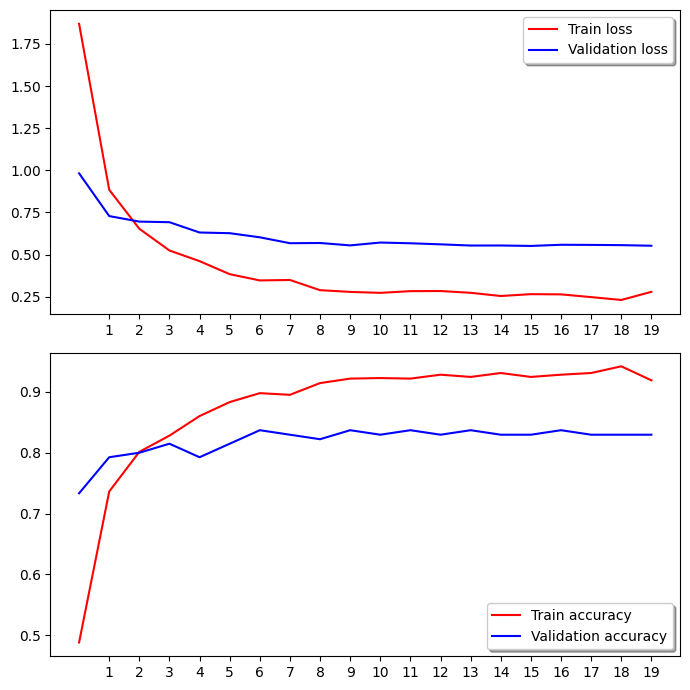

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(hist.history['loss'], color='r', label="Train loss")
ax1.plot(hist.history['val_loss'], color='b', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
legend = ax1.legend(loc='best', shadow=True)

ax2.plot(hist.history['accuracy'], color='r', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='b',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
legend = ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [41]:
y_pred_val = inception_model.predict(validation_generator)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step


In [42]:
y_true_val = y_val.argmax(axis=1)
y_pred_val = y_pred_val.argmax(axis=1)

In [43]:
loss, acc = inception_model.evaluate(validation_generator, verbose=0)
print(f'Validation loss: {loss:.2f}%')
print(f'Validation accuracy: {acc*100:.2f}%')

Validation loss: 0.55%
Validation accuracy: 82.96%


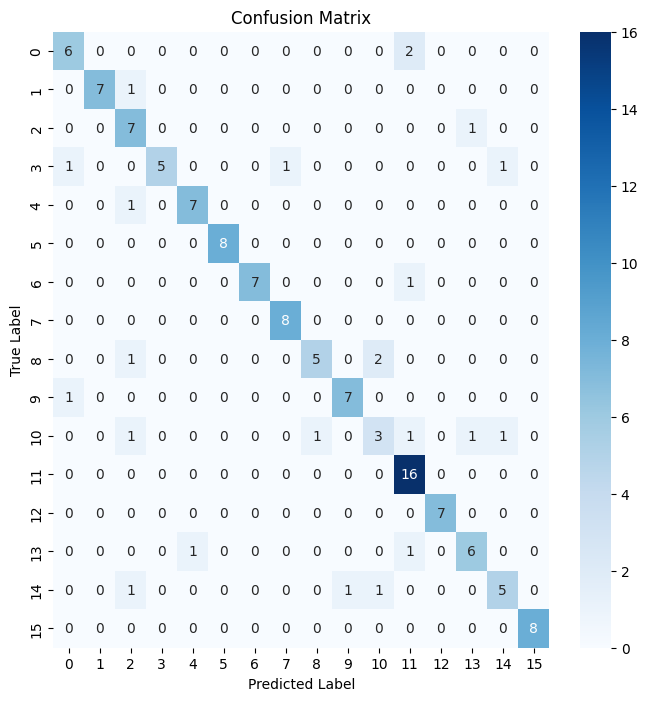

In [44]:
confusion_mtx = confusion_matrix(y_true_val, y_pred_val) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [45]:
samples = total_X_test

In [46]:
predict = inception_model.predict(test_generator)

 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step

C:\Users\Jovita\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


In [47]:
loss, acc = inception_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {loss:.2f}%')
print(f'Test accuracy: {acc*100:.2f}%')

Test loss: 0.58%
Test accuracy: 81.75%


In [48]:
y_pred = predict.argmax(axis=1)
y_true = y_test.argmax(axis=1)

In [49]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      0.75      0.86         8
           2       0.53      1.00      0.70         8
           3       0.75      0.38      0.50         8
           4       0.75      0.38      0.50         8
           5       1.00      1.00      1.00         9
           6       0.73      1.00      0.84         8
           7       0.78      0.88      0.82         8
           8       1.00      1.00      1.00         8
           9       0.88      0.88      0.88         8
          10       0.88      0.88      0.88         8
          11       0.93      0.88      0.90        16
          12       1.00      0.88      0.93         8
          13       0.83      0.62      0.71         8
          14       0.60      0.75      0.67         8
          15       0.88      0.88      0.88         8

    accuracy                           0.82       137
   macro avg       0.83   

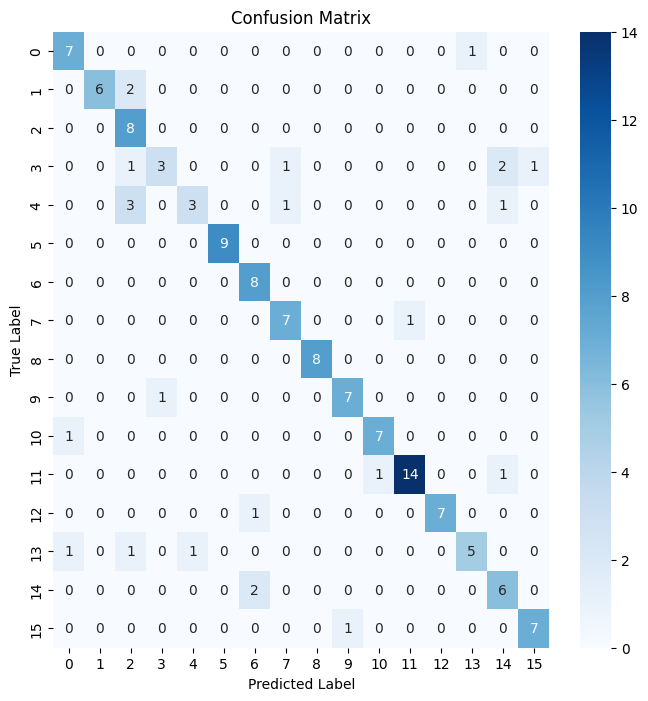

In [50]:
confusion_mtx = confusion_matrix(y_true, y_pred) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


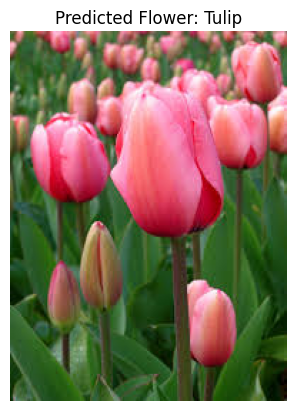

The predicted flower is: Tulip


In [51]:
category = ["Bluebell", "Buttercup", "Cowslip", "Crocus", "Daffodil", "Daisy", "Dandelion", "Fritillary", "Iris", "Pansy", "Rose" ,"Snowdrop", "Sunflower", "Tiger Lily", "Tulip", "Windflower"]
def preprocess_input_image(img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0
    return img_array
def predict_flower(img_path, model):
    img_array = preprocess_input_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    flower_name = category[predicted_class_idx]

    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f"Predicted Flower: {flower_name}")
    plt.show()

    return flower_name

img_path = './tulip.jpg'
predicted_flower = predict_flower(img_path, inception_model)
print(f"The predicted flower is: {predicted_flower}")

In [52]:
import pickle
with open('./model_inception.h5', 'wb') as f :
    pickle.dump(inception_model,f)
    f.close()